In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [4]:
import pyspark.pandas as ps

/content/spark-3.5.0-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.mllib.evaluation import RegressionMetrics
import sys
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
spark = SparkSession.builder.appName("Jena_Climate").getOrCreate()

In [7]:
def load_data():
    df=spark.read.option("header", "true").csv("jena_climate_2009_2016.csv")
    return df

-----Weather Data-----
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|          Date Time|p (mbar)|T (degC)|Tpot (K)|Tdew (degC)|rh (%)|VPmax (mbar)|VPact (mbar)|VPdef (mbar)|sh (g/kg)|H2OC (mmol/mol)|rho (g/m**3)|wv (m/s)|max. wv (m/s)|wd (deg)|
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|01.01.2009 00:10:00|  996.52|   -8.02|  265.40|      -8.90| 93.30|        3.33|        3.11|        0.22|     1.94|           3.12|     1307.75|    1.03|         1.75|  152.30|
|01.01.2009 00:20:00|  996.57|   -8.41|  265.01|      -9.28| 93.40|        3.23|        3.02|        0.21|     1.89|           3.03|     1309.80|    0.72|         1.50|  136.10|
|01.01.2009 00:30:00|  996.53|   -8.51|  264.91|      -9.31| 93.90|        3.21|       

/content/spark-3.5.0-bin-hadoop3/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/content/spark-3.5.0-bin-hadoop3/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


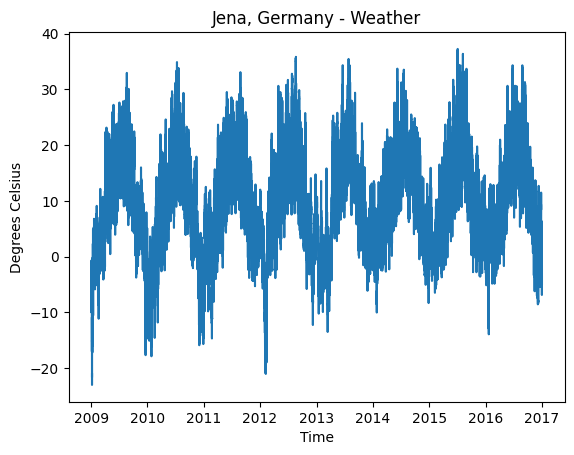

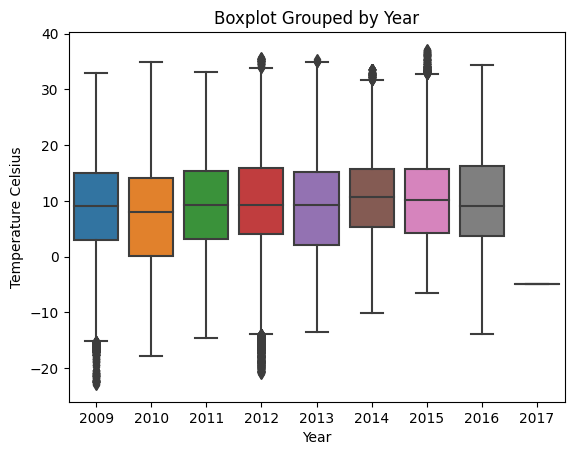

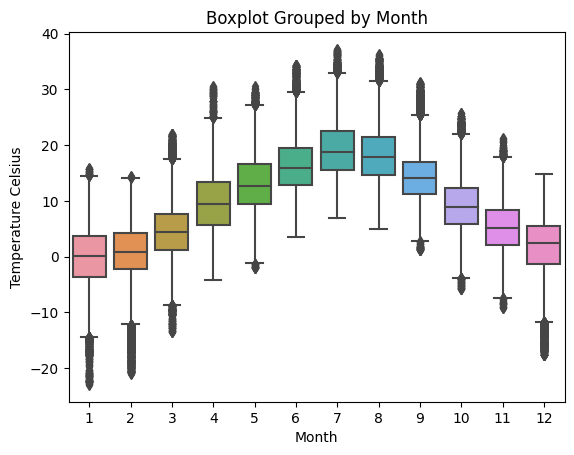

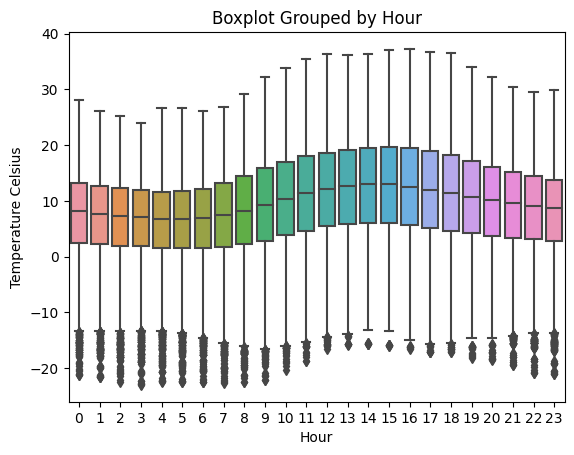

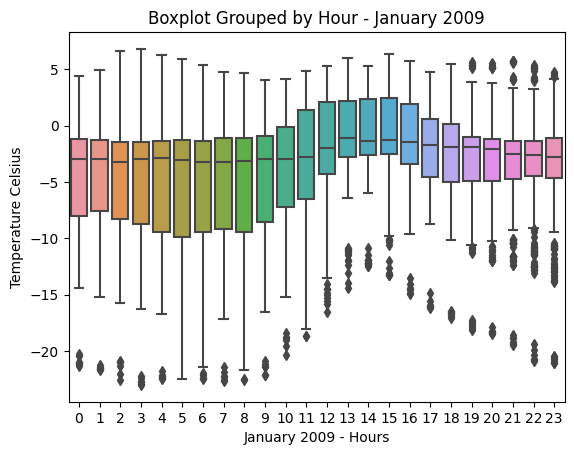

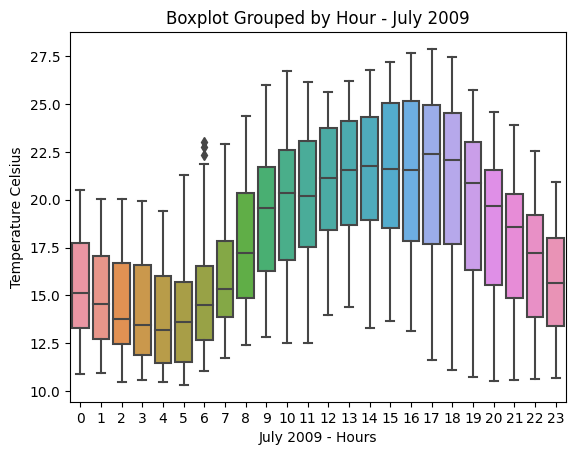

In [8]:
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import calendar

if __name__ == "__main__":

    #load and preprocess data
    data = load_data()

    print("-----Weather Data-----")
    data.show()
    print("-----Weather Data Schema-----")
    data.printSchema()

    data = data.withColumn("date_time_ts",F.to_timestamp(col("Date Time"),'dd.MM.yyyy HH:mm:ss'))
    data = data.withColumn("year", F.year(col("date_time_ts")))
    data = data.withColumn("month", F.month(col("date_time_ts")))
    data = data.withColumn("hour", F.hour(col("date_time_ts")))

    data = data.withColumn("p (mbar)", when(col("p (mbar)") == "", None).otherwise(col("p (mbar)").cast("double")))
    data = data.withColumn("T (degC)", when(col("T (degC)") == "", None).otherwise(col("T (degC)").cast("double")))
    data = data.withColumn("VPmax (mbar)", when(col("VPmax (mbar)") == "", None).otherwise(col("VPmax (mbar)").cast("double")))
    data = data.withColumn("VPdef (mbar)", when(col("VPdef (mbar)") == "", None).otherwise(col("VPdef (mbar)").cast("double")))
    data = data.withColumn("sh (g/kg)", when(col("sh (g/kg)") == "", None).otherwise(col("sh (g/kg)").cast("double")))
    data = data.withColumn("rho (g/m**3)", when(col("rho (g/m**3)") == "", None).otherwise(col("rho (g/m**3)").cast("double")))
    data = data.withColumn("wv (m/s)", when(col("wv (m/s)") == "", None).otherwise(col("wv (m/s)").cast("double")))


    # Check the schema again and proceed with further analysis
    print("-----Processed Weather Data Schema-----")
    data.printSchema()

    temp_df = ps.DataFrame(data).set_index('date_time_ts')

    plt.figure(1)
    plt.plot(temp_df['T (degC)'])
    plt.xlabel("Time")
    plt.ylabel("Degrees Celsius")
    plt.title("Jena, Germany - Weather")
    pandas_df = data.toPandas()


    pandas_df['month_2'] = pandas_df['month'].apply(lambda x: calendar.month_abbr[x])
    pandas_df['month_hr'] = pandas_df['month_2'].astype(str) + pandas_df['hour'].astype(str)

    pandas_jan__2009 = pandas_df.query('year == 2009 & month == 1')
    pandas_july__2009 = pandas_df.query('year == 2009 & month == 7')


    pandas_df__2009_2012 = pandas_df.query('year <= 2012')


    plt.figure(2)
    sns.boxplot (x='year', y= 'T (degC)', data=pandas_df).set(xlabel='Year', ylabel='Temperature Celsius', title = 'Boxplot Grouped by Year')

    plt.figure(3)
    sns.boxplot (x='month', y='T (degC)', data=pandas_df).set(xlabel='Month', ylabel='Temperature Celsius', title = 'Boxplot Grouped by Month')

    plt.figure(4)
    sns.boxplot (x='hour', y='T (degC)', data=pandas_df).set(xlabel='Hour', ylabel='Temperature Celsius', title = 'Boxplot Grouped by Hour')

    plt.figure(5)
    sns.boxplot (x='hour', y='T (degC)', data=pandas_jan__2009).set(xlabel='January 2009 - Hours', ylabel='Temperature Celsius', title = 'Boxplot Grouped by Hour - January 2009')

    plt.figure(6)
    sns.boxplot (x='hour', y='T (degC)', data=pandas_july__2009).set(xlabel='July 2009 - Hours', ylabel='Temperature Celsius', title = 'Boxplot Grouped by Hour - July 2009')

    plt.show()

In [9]:
from pandas.plotting import autocorrelation_plot

pandas_df_temp = pandas_df[['T (degC)', 'date_time_ts']]
pandas_df_temp.set_index('date_time_ts', inplace=True)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

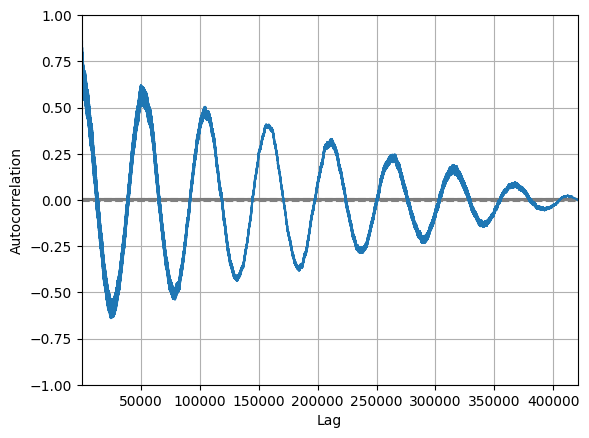

In [10]:
autocorrelation_plot(pandas_df_temp['T (degC)'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

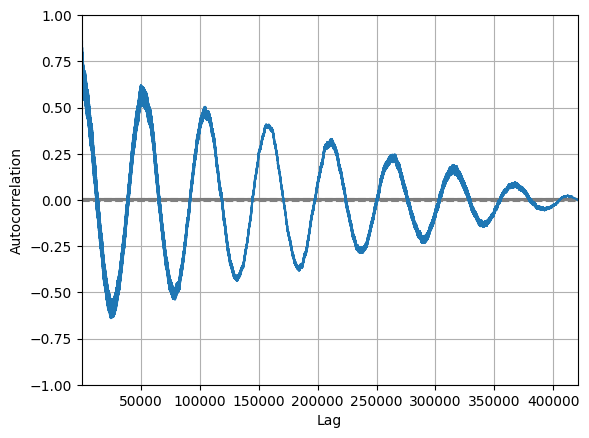

In [11]:
from pandas.plotting import autocorrelation_plot

pandas_df_temp = pandas_df[['T (degC)', 'date_time_ts']]
pandas_df_temp.set_index('date_time_ts', inplace=True)

autocorrelation_plot(pandas_df_temp['T (degC)'])

In [12]:
from statsmodels.tsa.stattools import adfuller

pandas_df__2009_2012.info()
print()
display(pandas_df__2009_2012)

pdf_09_12_temperature = pandas_df__2009_2012[['T (degC)', 'date_time_ts']]
pdf_09_12_temperature.set_index('date_time_ts', inplace=True)


adf1, pvalue1, usedlag_1, nobs1, critical_values_1, icbest_1 = adfuller(pdf_09_12_temperature)
print("pvalue = ", pvalue1, "Data - not trend stationary when value > 0.05")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210525 entries, 0 to 210524
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        210525 non-null  object        
 1   p (mbar)         210525 non-null  float64       
 2   T (degC)         210525 non-null  float64       
 3   Tpot (K)         210525 non-null  object        
 4   Tdew (degC)      210525 non-null  object        
 5   rh (%)           210525 non-null  object        
 6   VPmax (mbar)     210525 non-null  float64       
 7   VPact (mbar)     210525 non-null  object        
 8   VPdef (mbar)     210525 non-null  float64       
 9   sh (g/kg)        210525 non-null  float64       
 10  H2OC (mmol/mol)  210525 non-null  object        
 11  rho (g/m**3)     210525 non-null  float64       
 12  wv (m/s)         210525 non-null  float64       
 13  max. wv (m/s)    210525 non-null  object        
 14  wd (deg)         210

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),date_time_ts,year,month,hour,month_2,month_hr
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,...,1307.75,1.03,1.75,152.30,2009-01-01 00:10:00,2009,1,0,Jan,Jan0
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,...,1309.80,0.72,1.50,136.10,2009-01-01 00:20:00,2009,1,0,Jan,Jan0
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,...,1310.24,0.19,0.63,171.60,2009-01-01 00:30:00,2009,1,0,Jan,Jan0
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,...,1309.19,0.34,0.50,198.00,2009-01-01 00:40:00,2009,1,0,Jan,Jan0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,...,1309.00,0.32,0.63,214.30,2009-01-01 00:50:00,2009,1,0,Jan,Jan0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210520,31.12.2012 23:10:00,983.74,6.78,281.26,1.42,68.51,9.88,6.77,3.11,4.29,...,1220.98,4.11,5.13,187.70,2012-12-31 23:10:00,2012,12,23,Dec,Dec23
210521,31.12.2012 23:20:00,983.73,6.38,280.86,1.35,70.10,9.61,6.74,2.87,4.27,...,1222.74,3.69,5.29,178.20,2012-12-31 23:20:00,2012,12,23,Dec,Dec23
210522,31.12.2012 23:30:00,983.77,6.01,280.48,1.36,72.00,9.37,6.74,2.62,4.27,...,1224.41,2.33,4.24,184.60,2012-12-31 23:30:00,2012,12,23,Dec,Dec23
210523,31.12.2012 23:40:00,983.75,5.87,280.34,1.38,72.80,9.27,6.75,2.52,4.28,...,1225.01,2.61,3.38,171.50,2012-12-31 23:40:00,2012,12,23,Dec,Dec23


pvalue =  2.1785320257353173e-13 if above 0.05, data is not stationary
